In [1]:
# import the needed librairies
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting

import seaborn as sns
color = sns.color_palette()

import warnings
warnings.filterwarnings('ignore') #Supress unnecessary warnings for readability and cleaner presentation

pd.set_option('display.float_format', lambda x: '%.3f' % x) #Limiting floats output to 3 decimal points

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
order_products_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/order_products__train.csv')
order_products_prior = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/order_products__prior.csv')
orders = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/orders.csv')
products = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/products.csv')
aisles = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/aisles.csv')
departments = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/departments.csv')



In [5]:
order_products_all = pd.concat([order_products_train, order_products_prior], axis=0)
#handle missing data

total = order_products_all.isnull().sum().sort_values(ascending=False)
percent = (order_products_all.isnull().sum()/order_products_all.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])
missing_data

,Total Missing,Percent
order_id,0,0.000
product_id,0,0.000
add_to_cart_order,0,0.000
reordered,0,0.000


In [6]:
# Check the number of unique orders and unique products
orders_Unique = len(set(order_products_all.order_id))
products_Unique = len(set(order_products_all.product_id))
print("There are %s orders for %s products" %(orders_Unique, products_Unique))

There are 3346083 orders for 49685 products


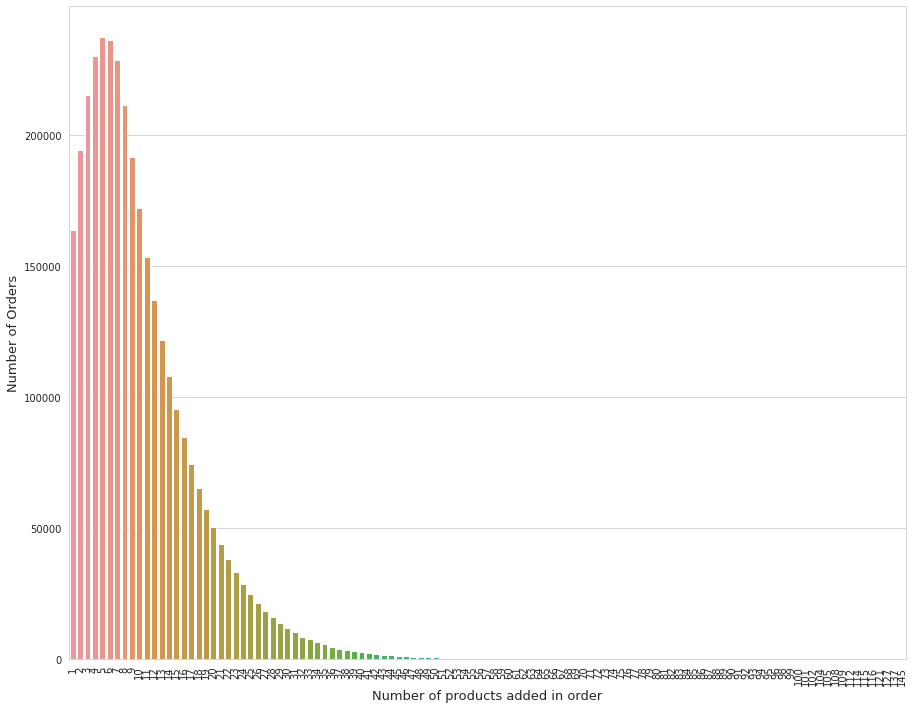

In [7]:
#Number of products that people usually order:

grouped = order_products_all.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
grouped = grouped.add_to_cart_order.value_counts()

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)

plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Number of products added in order', fontsize=13)
plt.show()

In [27]:
grouped = order_products_all.groupby("product_id")["reordered"].aggregate('count').reset_index()
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped = grouped.rename(columns={'reordered': 'Total_reorders'})
grouped = grouped.sort_values(by='Total_reorders', ascending=False)[:10]

grouped.drop('product_name_y', axis=1, inplace=True)
grouped = grouped.rename(columns={'product_name_x': 'product_name'})
grouped


,product_id,Total_reorders,product_name
24849,24852,491291,Banana
13173,13176,394930,Bag of Organic Bananas
21134,21137,275577,Organic Strawberries
21900,21903,251705,Organic Baby Spinach
47205,47209,220877,Organic Hass Avocado
47762,47766,184224,Organic Avocado
47622,47626,160792,Large Lemon
16794,16797,149445,Strawberries
26206,26209,146660,Limes
27842,27845,142813,Organic Whole Milk


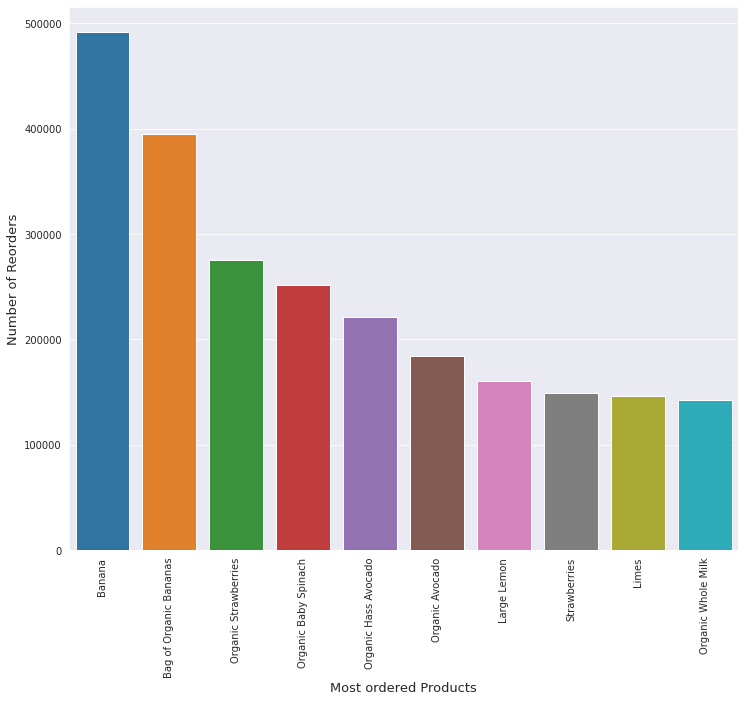

In [28]:
grouped  = grouped.groupby(['product_name']).sum()['Total_reorders'].sort_values(ascending=False)

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of Reorders', fontsize=13)
plt.xlabel('Most ordered Products', fontsize=13)
plt.show()

In [34]:
#Do people usually reorder the same previous ordered products?

grouped = order_products_all.groupby("reordered")["product_id"].aggregate('count').reset_index()
grouped = grouped.rename(columns={'product_id': 'Total_products'})

grouped['Ratios'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped

,reordered,Total_products,Ratios
0,0,13863746,0.410
1,1,19955360,0.590


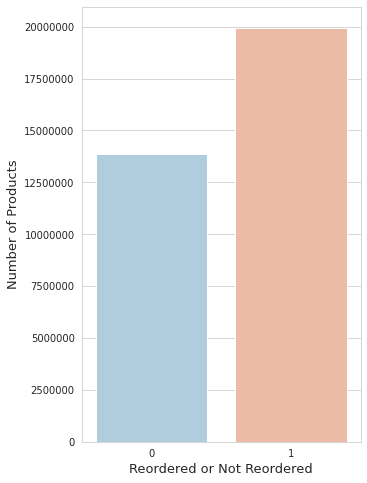

In [35]:
grouped  = grouped.groupby(['reordered']).sum()['Total_products'].sort_values(ascending=False)

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(5, 8))
sns.barplot(grouped.index, grouped.values, palette='RdBu_r')
plt.ylabel('Number of Products', fontsize=13)
plt.xlabel('Reordered or Not Reordered', fontsize=13)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [37]:
orders_na = (orders.isnull().sum() / len(orders)) * 100
orders_na = orders_na.drop(orders_na[orders_na == 0].index).sort_values(ascending=False)
orders_na

days_since_prior_order   6.028
dtype: float64

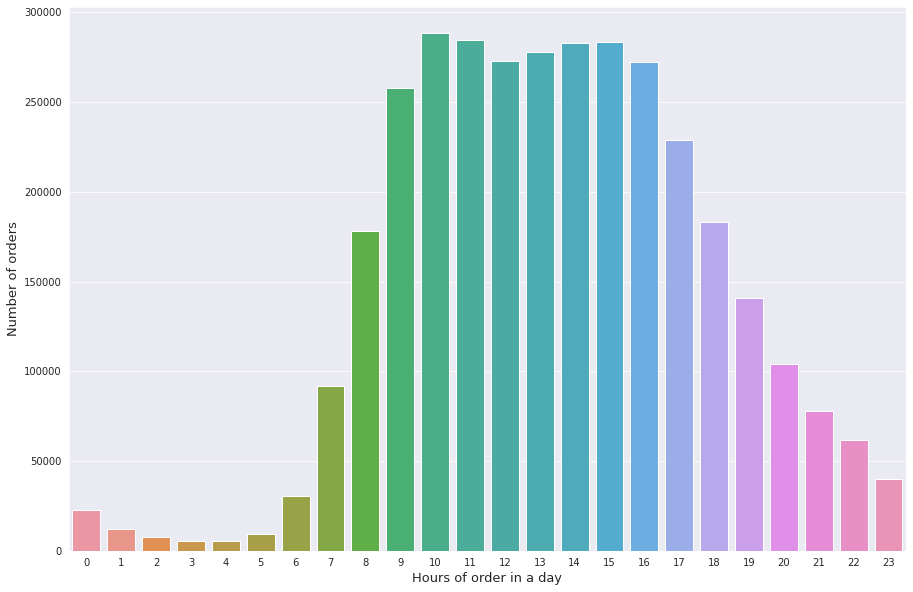

In [38]:
grouped = orders.groupby("order_id")["order_hour_of_day"].aggregate("sum").reset_index()
grouped = grouped.order_hour_of_day.value_counts()

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Hours of order in a day', fontsize=13)
plt.show()

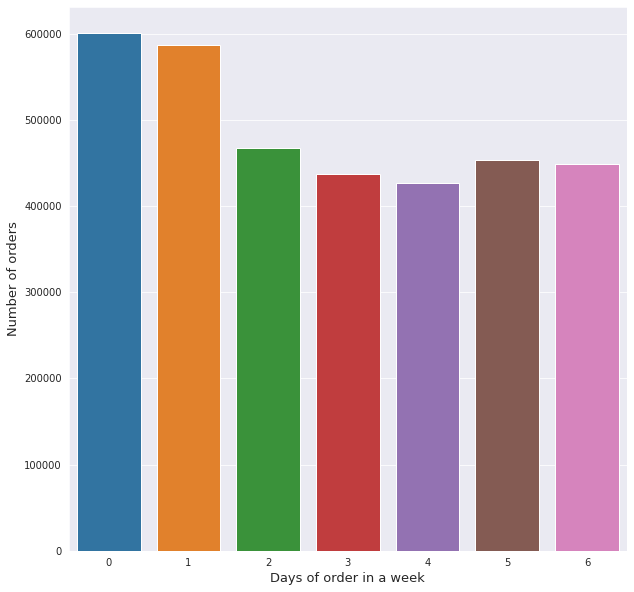

In [39]:
grouped = orders.groupby("order_id")["order_dow"].aggregate("sum").reset_index()
grouped = grouped.order_dow.value_counts()

f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Days of order in a week', fontsize=13)
plt.show()

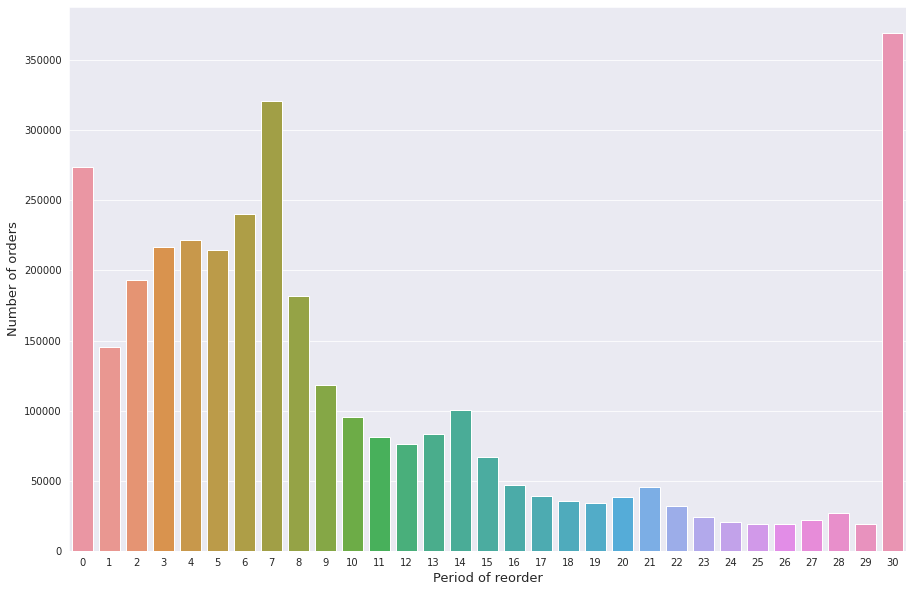

In [40]:
grouped = orders.groupby("order_id")["days_since_prior_order"].aggregate("sum").reset_index()
grouped = grouped.days_since_prior_order.value_counts()

from matplotlib.ticker import FormatStrFormatter
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(grouped.index, grouped.values)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Period of reorder', fontsize=13)
plt.show()

In [41]:
items = pd.merge(left =pd.merge(left=products, right=departments, how='left'), right=aisles, how='left')
items.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation


In [45]:
grouped = items.groupby("department")["product_id"].aggregate( 'count').reset_index()

grouped = grouped.rename(columns={'product_id': 'Total_products'})
grouped['Ratio'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped.sort_values(by='Total_products', ascending=False, inplace=True)
grouped

,department,Total_products,Ratio
17,personal care,6563,0.132
20,snacks,6264,0.126
16,pantry,5371,0.108
3,beverages,4365,0.088
10,frozen,4007,0.081
7,dairy eggs,3449,0.069
11,household,3085,0.062
6,canned goods,2092,0.042
9,dry goods pasta,1858,0.037
19,produce,1684,0.034


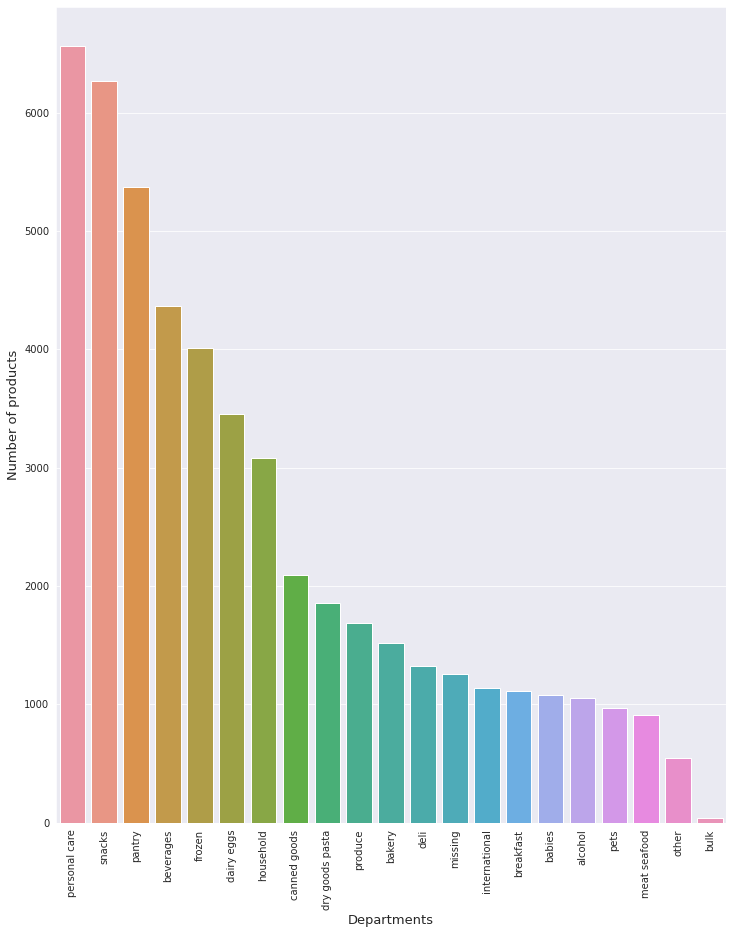

In [46]:
grouped = grouped.groupby(['department']).sum()['Total_products'].sort_values(ascending=False)

sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of products', fontsize=13)
plt.xlabel('Departments', fontsize=13)
plt.show()

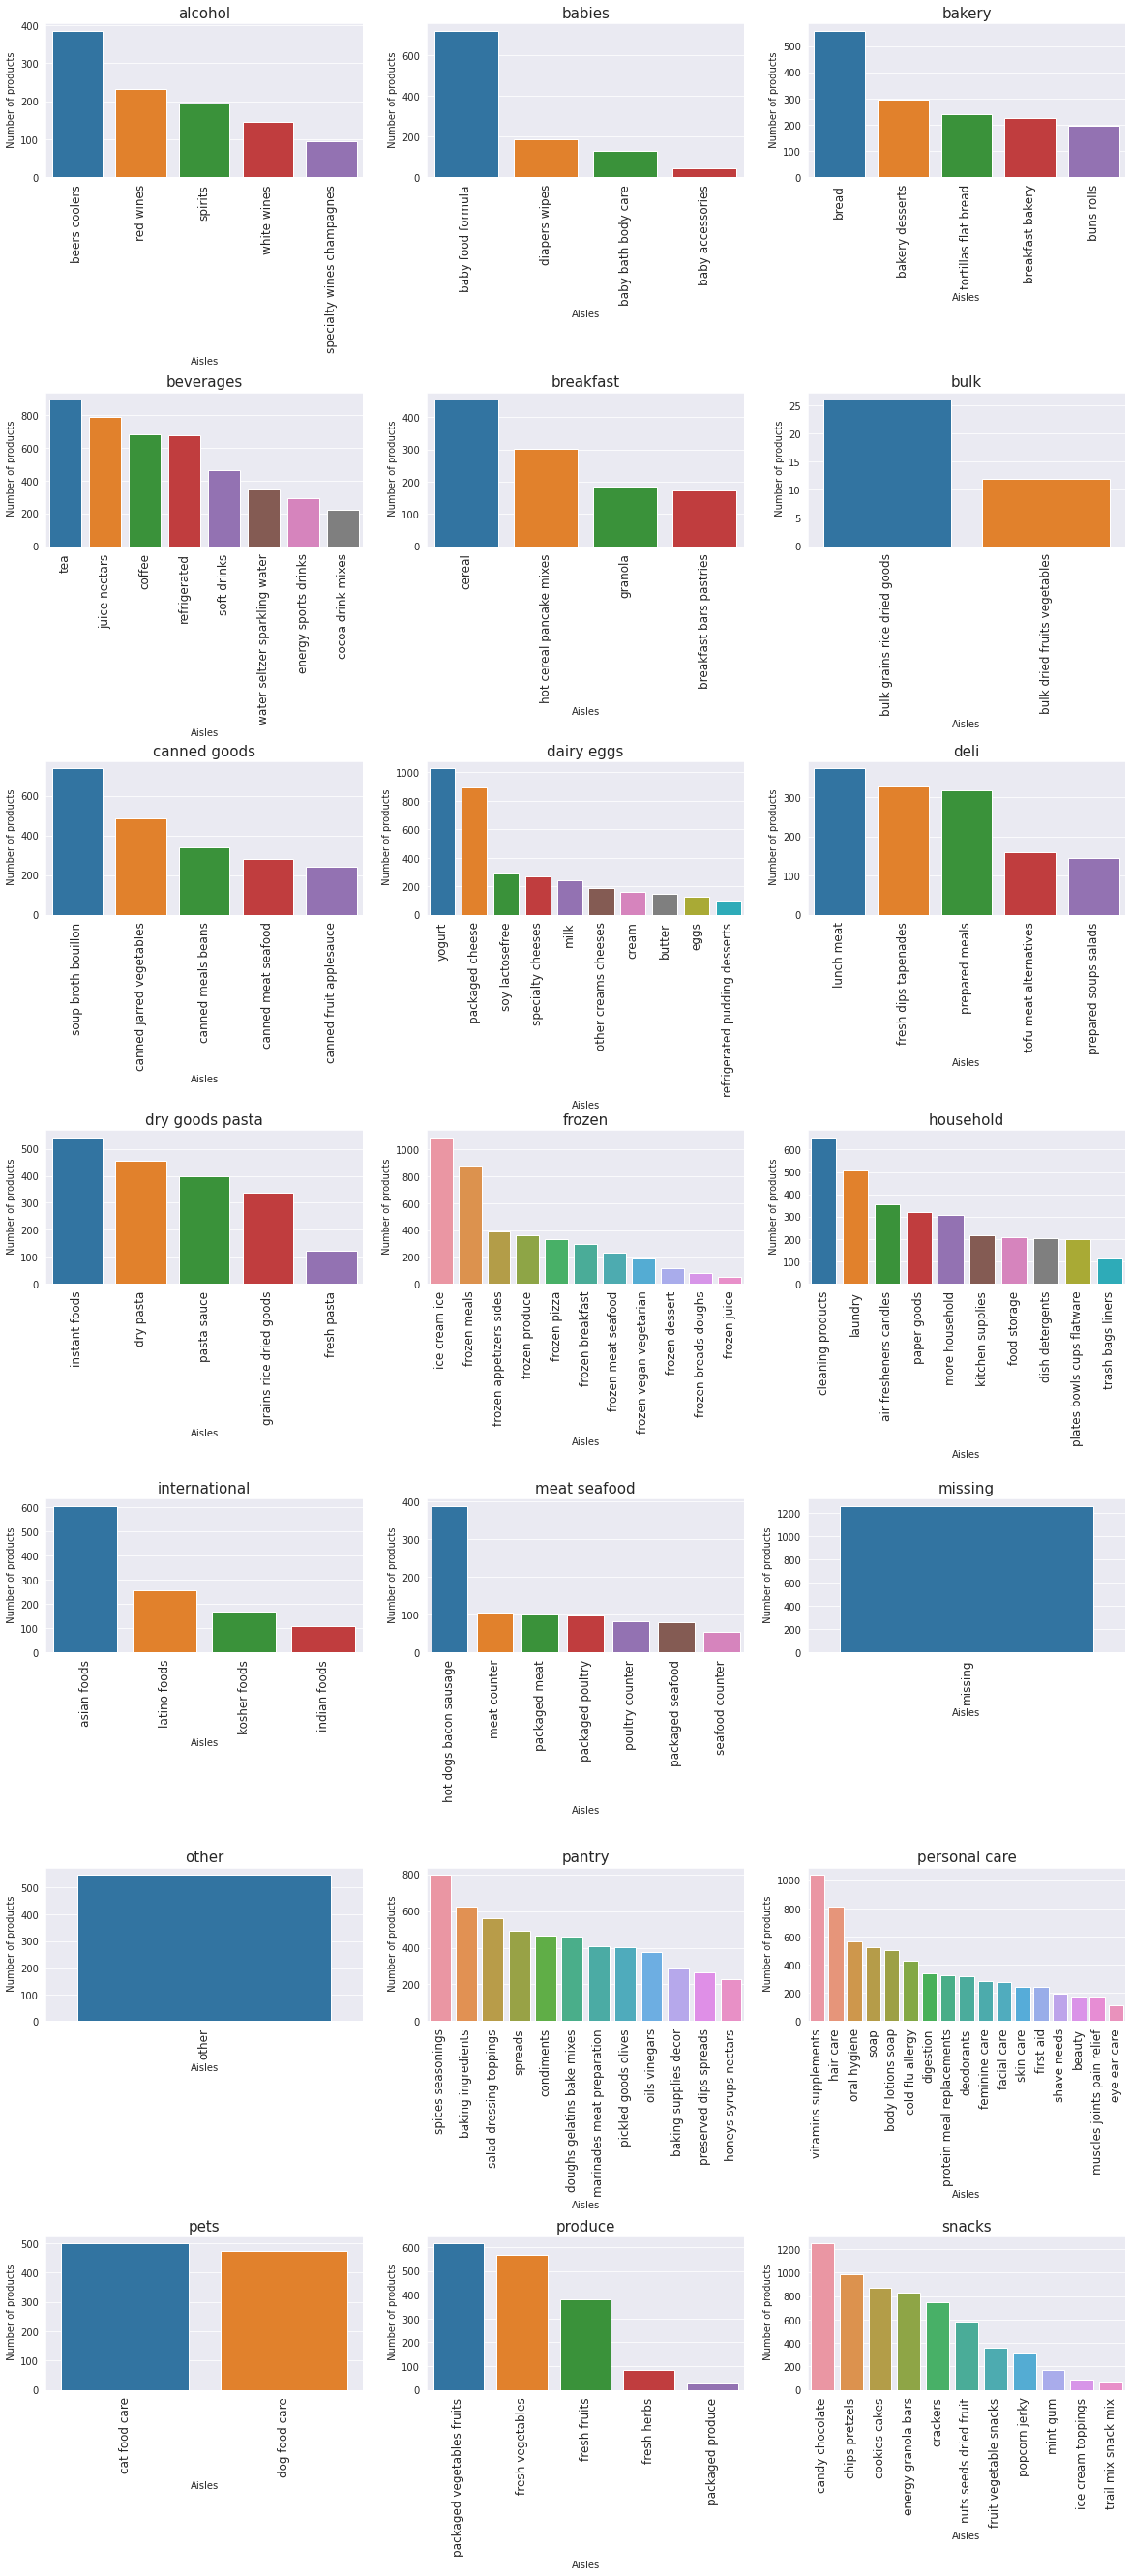

In [49]:
#Most important Aisles in each Department (by number of Products)

grouped = items.groupby(["department", "aisle"])["product_id"].aggregate('count').reset_index()

grouped = grouped.rename(columns={'product_id': 'Total_products'})

grouped.sort_values(by='Total_products', ascending=False, inplace=True)

fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))

for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(group.aisle, group.Total_products , ax=ax)
    ax.set(xlabel = "Aisles", ylabel=" Number of products")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)